# Triangular lattice UHF to RHF rotation

In [1]:
import numpy as np
from pyscf import gto, scf, fci, tools

a = 2 # A

coords = [
    (0.0*a, 0.0, 0.0),
    (1.0*a, 0.0, 0.0),
    (2.0*a, 0.0, 0.0),
    (3.0*a, 0.0, 0.0),
    (4.0*a, 0.0, 0.0),
    (5.0*a, 0.0, 0.0),
]

geometry = '; '.join([f'H {x:.8f} {y:.8f} {z:.8f}' for x,y,z in coords])
mol = gto.Mole()
mol.build(
    atom=geometry,
    unit='Angstrom',
    basis='sto-3g',
    charge=0,
    spin=0,
    verbose=0,
)

In [2]:
from pyscf import scf
from sd_qsci.utils import uhf_from_rhf, uhf_to_rhf_unitaries

rhf = scf.RHF(mol)
guess = rhf.get_init_guess(mol=mol, key="hcore")
rhf.kernel(dm0=guess)
uhf = uhf_from_rhf(mol, rhf)
Ua, Ub = uhf_to_rhf_unitaries(mol, rhf, uhf)

In [3]:
np.array([1, 1, 1, 0, 0, 0]) @ Ua

array([ 1.06563133, -0.2819329 ,  0.83769691,  0.74221369,  0.27692257,
        0.67501136])

In [4]:
print(uhf.mo_coeff[0] @ Ua)

[[ 0.25078041 -0.43969189 -0.43691386  0.47090291 -0.50348657 -0.30367601]
 [ 0.36063138 -0.47657505 -0.28626057 -0.27965741  0.54954726  0.45829769]
 [ 0.46720617 -0.12984081  0.45273147 -0.47755031 -0.17169847 -0.57610431]
 [ 0.46720617  0.12984081  0.45273147  0.47755031 -0.17169847  0.57610431]
 [ 0.36063138  0.47657505 -0.28626057  0.27965741  0.54954726 -0.45829769]
 [ 0.25078041  0.43969189 -0.43691386 -0.47090291 -0.50348657  0.30367601]]


In [5]:
print(rhf.mo_coeff)

[[ 0.25078041 -0.43969189 -0.43691386  0.47090291 -0.50348657 -0.30367601]
 [ 0.36063138 -0.47657505 -0.28626057 -0.27965741  0.54954726  0.45829769]
 [ 0.46720617 -0.12984081  0.45273147 -0.47755031 -0.17169847 -0.57610431]
 [ 0.46720617  0.12984081  0.45273147  0.47755031 -0.17169847  0.57610431]
 [ 0.36063138  0.47657505 -0.28626057  0.27965741  0.54954726 -0.45829769]
 [ 0.25078041  0.43969189 -0.43691386 -0.47090291 -0.50348657  0.30367601]]


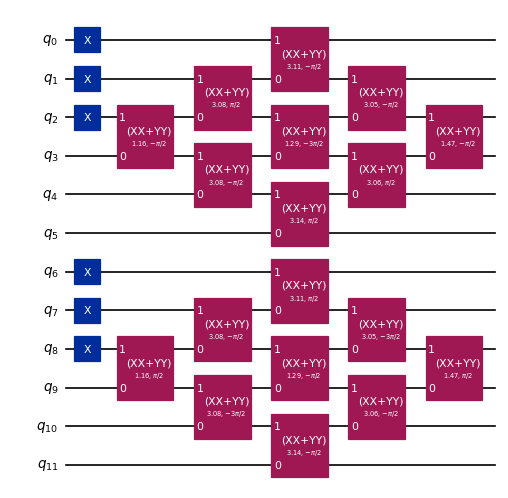

In [6]:
import ffsim
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, transpile
# from qiskit_ibm_runtime.fake_provider import FakeKyoto

# backend = FakeKyoto()
qubits = QuantumRegister(mol.nao*2, name="q")
qc = QuantumCircuit(qubits)

qc.append(ffsim.qiskit.PrepareHartreeFockJW(mol.nao, mol.nelec), qubits)
qc.append(ffsim.qiskit.OrbitalRotationJW(mol.nao, (Ua.T, Ub.T)), qubits)

# Optimize the orbital rotation circuit for single Slater det
qc = ffsim.qiskit.PRE_INIT.run(qc)
# qc_opt = transpile(qc, backend=backend, optimization_level=3)

# Decompose the orbital rotation into basic gates before drawing
decomposed = qc.decompose()
decomposed.draw("mpl", scale=0.6)

In [7]:
from qiskit_aer import Aer
from qiskit import transpile

# Transpile the circuit for the simulator
simulator = Aer.get_backend('statevector_simulator')
tqc = transpile(qc, simulator)

# Run and get results
job = simulator.run(tqc)
result = job.result()

# Extract the final statevector
statevector = result.get_statevector()

In [8]:
statevector.probabilities_dict()['111000111000']

np.float64(0.002325733713410737)

In [9]:
np.abs(statevector.data[int(0b111000111000)]) ** 2

np.float64(0.002325733713410737)

In [10]:
import pandas as pd

sv_abs = np.abs(statevector.data)
idx_sorted = np.argsort(sv_abs)[::-1]
sv_abs = sv_abs[idx_sorted]

bitstring_ints = np.arange(len(sv_abs))[idx_sorted]
bitstrings = [f"{x:012b}" for x in bitstring_ints]

df = pd.DataFrame({'Bitstring': bitstrings, 'Psi abs': sv_abs})
df = df.round(2)
print(df)

         Bitstring  Psi abs
0     000111000111     0.25
1     000111001011     0.22
2     001011000111     0.22
3     001011001011     0.20
4     010101000111     0.18
...            ...      ...
4091  100111111011     0.00
4092  100111111010     0.00
4093  100111111001     0.00
4094  100111111000     0.00
4095  101000000110     0.00

[4096 rows x 2 columns]


# My Hamiltonian

In [11]:
from sd_qsci.hamiltonian import hamiltonian_from_pyscf
H = hamiltonian_from_pyscf(mol, rhf)

In [12]:
qsci_energy = (statevector.data.conj() @ (H @ statevector.data)).real
uhf_energy = uhf.e_tot
rhf_energy = rhf.e_tot
print(qsci_energy, uhf_energy, rhf_energy)

-2.819489899125406 -2.8194898991254087 -2.3684212842825714


# FCI for comparison

In [13]:
from pyscf import fci

ci_solver = fci.FCI(rhf)
fci_energy, fci_vec = ci_solver.kernel()
fci_s2 ,mult = ci_solver.spin_square(fci_vec, mol.nao, mol.nelec)

# Calculate and compare energies

In [14]:
from scipy.sparse.linalg import eigsh

idx = np.argwhere(np.abs(statevector.data) > 1e-12).ravel()
print("# of configs:", len(idx))

H_sub = H[np.ix_(idx, idx)]
E0, psi0 = eigsh(H_sub, k=1, which='SA')

print("fci energy:", fci_energy)
print("rhf energy:", rhf.e_tot)
print("uhf energy:", uhf.e_tot)
print("qsci energy:", E0[0])
print("statevector expectation value:", (statevector.data.conj().T @ H @ statevector.data).real)

# of configs: 400
fci energy: -2.847192133955601
rhf energy: -2.3684212842825714
uhf energy: -2.8194898991254087
qsci energy: -2.8471921339556037
statevector expectation value: -2.819489899125406


In [15]:
rhf_bitstring = 0b000111000111
rhf_idx = int(rhf_bitstring)
print("rhf bitstring diag element", H[rhf_idx, rhf_idx].real) # check indexing is correct
print("rhf energy:", rhf.e_tot)

rhf bitstring diag element -2.368421284282568
rhf energy: -2.3684212842825714


# Calculate and compare spin

In [16]:
from sd_qsci.spin import total_spin_S2

S2_fermi = total_spin_S2(mol.nao)
rhf_s2 = S2_fermi[rhf_idx, rhf_idx].real # should be 0

# UHF total spin
uhf_s2, uhf_multiplicity = uhf.spin_square()

# QSCI subspace of S2 matrix
S2_fermi = S2_fermi[np.ix_(idx, idx)]

# psi is a normalized statevector (numpy complex array, dimension = 2**(2*norb))
qsci_s2 = psi0.conj().T @ S2_fermi @ psi0

print("fci spin:", fci_s2)
print("rhf spin:", rhf_s2)
print("uhf spin:", uhf_s2)
print("qsci spin:", qsci_s2)

fci spin: 1.2394976973285148e-28
rhf spin: 0.0
uhf spin: 2.740101089285723
qsci spin: [[-4.63647145e-19+2.28582701e-18j]]


/home/fredd/code/sd_qsci/src/sd_qsci/spin.py:12: SyntaxWarning: invalid escape sequence '\d'
  """
/home/fredd/code/sd_qsci/src/sd_qsci/spin.py:33: SyntaxWarning: invalid escape sequence '\d'
  """


# Check spin flipped states
See if for every sampled state the spin flipped state has also been sampled

In [19]:
from sd_qsci.utils import find_spin_symmetric_configs
sampled_configs, symm_configs = find_spin_symmetric_configs(n_bits=2*mol.nao, idx=idx)
sampled_configs == symm_configs

True

In [18]:
from scipy.sparse.linalg import eigsh

idx_symm = [int(x, 2) for x in symm_configs]
idx_symm = sorted(set(idx_symm))
print("# of configs:", len(idx_symm))
H_sub = H[np.ix_(idx_symm, idx_symm)]

E0, psi0 = eigsh(H_sub, k=1, which='SA')

print("fci energy:", fci_energy)
print("rhf energy:", rhf.e_tot)
print("uhf energy:", uhf.e_tot)
# print("qsci energy:", min(evals))
print("qsci energy:", E0)
print((psi0.conj().T @ H_sub @ psi0).real)

TypeError: int() can't convert non-string with explicit base